# Shiptracking (PlanetScope)

**Autor*in:** Julian Hausmann
**Copyright:** © 2025 Urbetho CF GmbH
**Lizenz:** Dieses Notebook steht unter der [CC BY-NC-SA 4.0 License](https://creativecommons.org/licenses/by-nc-sa/4.0/deed.en).

<div style="text-align: right"><i> Fortgeschritten </i></div>

In diesem Notizbuch erkennen wir Schiffsrümpfe mithilfe der hohen räumlichen Auflösung (~3 m) des Multispektralsensors SuperDove von Planet Labs. Die Erkennung von Schiffen aus dem Weltraum ist für Regierungsbehörden, Küstenwachen, Grenzschutzbehörden und Umweltorganisationen von großem Wert, um Häfen und Küsten zu überwachen, Schiffe zu verfolgen und verdächtige Aktivitäten in umstrittenen Gewässern zu identifizieren. SuperDove liefert genau wie Sentinel-2 optische Multispektraldaten - auf Grund der höheren Auflösung lassen sich jedoch besser kleine und mittel große Schiffe erkennen. Für die Shipdetection soll in diesem Fall ein nicht-überwachter Ansatz verwendet werden. Das bedeutet es werden keine Trainingsdaten verwendet, sondern der Algorithmus wird auf der Grundlage statistischer Kennwerte Pixel zu Objekten zusammenführen und zwei Klassen unterscheiden. Der Nutzende wird schließlich entscheiden, welche der beiden Klassen als Schiff und welche als Wasserfläche definiert wird. Der Workflow wurde um den unüberwachten Klassifikationsansatz K-Means entwickelt. Vor der Klassifikation wird das Verfahren der Kantenerkennung verwendet, durch das Kontraste zwischen benachbarten Pixelwerten erhöht werden. K-Means kann dadurch besser Objekte identifizieren. Im Anschluss wird das Bild geglättet und Rauschen entfernt. Erst dann erfolgt eine Polygonisierung und eine Darstellung der gefundenen Schiffsrümpfe.

Der SuperDove-Sensor ist auf über 135 Dove-Satelliten montiert, die die PlanetScope-Konstellation bilden. Durch die Anzahl der Satelliten ist man in der Lage (nahezu) täglich die gesamte Landoberfläche der Erde abzubilden. Neben der hohen zeitlichen Auflösung bieten die Satelliten eine sehr hohe räumliche Auflösung, die über die eigenen Satelliten der ESA nicht verfügbar ist - der optische Sensor des Sentinel-2 Satelliten kann lediglich mit 10 m räumliche Auflösung aufzeichnen. Als Beitrag zur Copernicus Data Space Ecosystem (CCM)-Mission können Nutzer*innen Zugriff auf Planet Daten erhalten. Über CODE-DE können Sie entweder solche Daten erhalten, die wir bereits in unserem **RESA-Archiv** gespeichert haben oder aber, sie beantragen den Zugriff auf **neue Daten** oder sogar ein **individuelles Tasking**. Die verschiedenen Möglichkeiten erklären wir Ihnen auch nochmal in den Einträgen zu PlanetScope in unserem [**CODE-DE Portfolio**](https://code-de.org/de/portfolio/).

Zugriff zu den Daten erhalten wir über eine **Virtuelle Maschine (VM)**. Wie Sie den Zugang zu einer VM erhalten lesen Sie ebenfalls im [**CODE-DE Portfolio**](https://code-de.org/de/portfolio/) unter dem Eintrag Virtuelle Maschinen. Der Zugang beschleunigt die Arbeit mit den Daten, da langwierige Downloads wegfallen. **Das Notebook kann auch für andere Küstengebiete ausprobiert werden. Dabei müssen nur an wenigen Stellen im Skript Änderungen vorgenommen werden. Entscheidende Stelle ist dabei die Auswahl der PlanetScope Szene, aber auch bei der Auswahl der Parameter für die Segmentierung des Bildes müssen wahrscheinlich Änderungen vorgenommen werden. Viele Stellen bleiben komplett gleich - das Skript ist entsprechend automatisiert.**

**General Note 1**: Ausführung der Zellen durch pressen des <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button vom top MENU (oder `Shift` + `Enter`).

**General Note 2**: Falls der Kern nich mehr arbeitet, im the top MENU, klicke <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Dann, im top MENU, clicke  "Run" aund wähle "Run All Above Selected Cell".

**General Note 3**: Schauen Sie sich im [**FORUM**](https://forum.code-de.org/de/) um oder Kontaktieren Sie den Support! 
<br>

<img src="https://live.staticflickr.com/7466/15442543434_e03ed99244_b.jpg">

*Die Abbildung zeigt symbolhaft die Routen von verschiedenen Schiffen aus einem Hafengebiet. Bevor solche Linien für längere Zeiträume gezeichnet werden können, müssen die Schiffe für einen Zeitpunkt getracked werden. Die Abbildung kann [hier](https://www.flickr.com/photos/ericsoco/15442543434/) unter dieser [Lizenz](https://creativecommons.org/licenses/by-nc-sa/2.0/deed.en) abgerufen werden.*

#### 1. Installieren der benötigten Bibliotheken

Verschiedene Pakete müssen installiert werden, bevor Zugriff und Analyse der Daten gestartet werden können. Die Liste der zu installierenden Bibliotheken ist abhängig von den bereits lokal installierten Bibliotheken und muss dementsprechend erweitert werden, falls Bedarf besteht. 

In [1]:
!pip install opencv-python
!pip install rasterio
!pip install matplotlib 
!pip install pandas

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


#### 2. Importieren der benötigten Bibliotheken

Viele der unten genannten Bibliotheken mussten nicht installiert werden, weil sie entweder bereits installiert wurden oder zu einer generellen Installation von Python zugehörig sind. Ohne die Bibliotheken ist das folgende Skript nicht ausführbar.

In [2]:
# Versuche, installierte Pakete zu importieren
try:

  # Liste der notwendigen zu importierenden Pakete
    import rasterio
    import numpy as np
    import rasterio.features
    import geopandas as gpd
    from shapely.geometry import shape, MultiPolygon, Polygon, box
    import cv2
    from rasterio.features import rasterize
    from sklearn.cluster import KMeans
    from skimage.measure import label, regionprops
    import os
    import folium
    import matplotlib.pyplot as plt
    import rasterio
    import rasterio.features
    from rasterio.warp import transform_bounds
    
    # Ausgabe
    print("Erfolgreicher Import aller benötigter Pakete.")
except:

    # Ausgabe
    print("Nicht alle benötigten Pakete konnten erfolgreich importiert werden.")

Erfolgreicher Import aller benötigter Pakete.


#### 3. Plot-Funktion 

Wir werden in diesem Notebook versuchen möglichst viele visuelle Outputs in Form von Plots zu erzeugen. Dadurch wird es leichter den Workflow und den Roten Faden zu verstehen. Damit die Plots ähnlich aussehen, erstellen wir zu Beginn eine Plot-Funktion, die wir dann im Laufe des Notebooks mehrmals aufrufen werden. Da unser Plot auf Raster-, Vektor- oder einer Kombination aus beiden Datentypen bestehen wird, haben wir Optionen für verschiedene Datentypen eingebaut.

In [3]:
def plot_function(image=None, title=None, brightness_factor=None, colour_ramp=None, 
                  polygon=None, ships=None, mask=None, extent=None):
    """
    Stellt Rasterbild mit optionalen Vektor-Overlays (Polygone, Schiffe, Wassermaske) dar.
    
    Args:
        image (np.array): Rasterbilddaten (2D-Array).
        title (str): Titel für die Darstellung.
        brightness_factor (float): Faktor zur Anpassung der Helligkeit des Bildes.
        colour_ramp (str): Farbskala (Colormap) für das Rasterbild.
        polygon (shapely.geometry.Polygon oder MultiPolygon): Optionales Polygon (oder Polygone) zum Überlagern.
        ships (GeoDataFrame): Optionales GeoDataFrame, das Schiffsgrenzen enthält.
        mask (GeoDataFrame): Optionales GeoDataFrame, das die Grenzen der Wassermaske enthält.
        extent (list): Der Ausdehnungsbereich (Extent) des Rasterbildes ([links, rechts, unten, oben]).
    """
    
    # Erstellen der Abbildung und Achsen
    fig, ax = plt.subplots(figsize=(10, 10))
    
    # Wenn ein Bild bereitgestellt wird (für Rasterdaten)
    if image is not None:
        if brightness_factor is not None and brightness_factor > 0:
            image = np.clip(image * brightness_factor, 0, 1)  # Helligkeit anpassen
        # Sicherstellen, dass der Ausdehnungsbereich (Extent) für Rasterbilder bereitgestellt wird
        if extent is None:
            raise ValueError("Extent muss bei der Darstellung eines Rasterbildes bereitgestellt werden.")
        img = ax.imshow(image, cmap=colour_ramp, extent=extent)
    
    # Wenn ein Polygon bereitgestellt wird (für Vektordaten)
    if polygon is not None:
        # Wenn es sich um ein MultiPolygon handelt, iteriere durch die Geometrien
        if isinstance(polygon, MultiPolygon):
            for poly in polygon.geoms:
                x, y = poly.exterior.xy
                ax.plot(x, y, color='blue')
                ax.fill(x, y, color='lightblue', alpha=0.5)
        elif isinstance(polygon, Polygon):  # Einzelnes Polygon
            x, y = polygon.exterior.xy
            ax.plot(x, y, color='blue')
            ax.fill(x, y, color='lightblue', alpha=0.5)
    
    # Wenn GeoDataFrames für Schiffe und Wassermasken bereitgestellt werden, stelle sie dar
    if ships is not None:
        ships.boundary.plot(ax=ax, color="red", linewidth=2, label="Ships")
    if mask is not None:
        mask.boundary.plot(ax=ax, color='blue', alpha=1, linewidth=2, label="Water Mask")
        
    # Farbleiste (Colorbar) hinzufügen, wenn colour_ramp bereitgestellt wird
    if colour_ramp is not None and image is not None:
        plt.colorbar(img)

    # Beschriftungen und Titel setzen
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title)
    
    # Legende hinzufügen, wenn Vektordaten dargestellt werden
    if ships is not None or mask is not None:
        plt.legend()
    
    plt.show()


#### 4. Öffnen der PlanetScope Szene

Beispielhaft wollen wir Ihnen hier den Zugang über das RESA-Archiv zeigen. Es gibt noch andere Möglichkeiten auf PlanetScope Daten zuzugreifen, diese werden nun aber vernachlässigt. Um eine passende Szene zu finden, können wir das Archiv durchsuchen. Wichtig ist hierbei, dass wir das Verzeichnis auf unserer VM gemountet haben. Hierbei ist eine Nutzeranfrage notwendig. Hierzu erhalten Sie Informationen im CODE-DE [**Portfolio**](https://code-de.org/de/portfolio/?id=93e87caa-0f9c-4066-8f12-7785e12d2d7a). Das Mounten der Daten wird im folgenden [**Knowledge-Base Artikel**](https://knowledgebase.code-de.org/en/latest/eodata/How-to-mount-eodata-using-S3FS-in-Linux-on-CODE-DE.html) beschrieben. Da es sich in dem Knowledge Base Artikel um das Mounten von EODATA handelt, müssen beim Mounten von PlanetScope Daten andere Credentials und ein anderer Zusatz zum fstab file genutzt werden. Um den Zugang zu den vorhandenen Daten im CODE-DE RESA-Archiv zu beantragen, gehen Sie bitte im Profilmanager von EO-Lab auf „Datenanfrage“, klicken Sie dann auf „Anfrage erstellen“ und wählen Sie „Datenzugang“. Ihr Antrag wird geprüft und Sie werden mit weiteren Informationen kontaktiert.  

Es ist hilfreich sich die PlanetScope Szenen über eine leaflet Karte anzeigen zu lassen. Dadurch können wir visuell direkt diejenigen Szenen bestimmen, die zu unserem Interesse passen, beispielsweise unsere Region oder generell Küstengebiete, an denen wir gerne Schiffe tracken möchten. 

In [8]:
# Definieren des Basisverzeichnisses für die GeoTIFF-Dateien (PlanetScope Satellitenbilder)
tif_directory = "/eolab/RESA-PlanetScope/PS2/PSOrthoTile/2020"

# Erstellen einer interaktiven Weltkarte, zentriert auf [0, 0] mit niedrigem Zoom.
m = folium.Map(
    location=[0, 0],
    zoom_start=2,
    tiles="https://tile.openstreetmap.org/{z}/{x}/{y}.png",
    attr="OpenStreetMap contributors"
)

# Durchsuchen des Verzeichnisses und Verarbeiten der TIF-Dateien
for root, dirs, files in os.walk(tif_directory):
    for filename in files:
        # Filtern nach relevanten GeoTIFF-Dateien ("bgrn_sr_cog" im Namen)
        if filename.lower().endswith(('.tif', '.tiff')) and "bgrn_sr_cog" in filename.lower():
            filepath = os.path.join(root, filename)
            
            try:
                with rasterio.open(filepath) as src:
                    # Transformieren der GeoTIFF-Begrenzung in das WGS84-Koordinatensystem (EPSG:4326)
                    wgs84_bounds = transform_bounds(src.crs, "EPSG:4326", *src.bounds)
                    
                    # Anpassen der Begrenzung für das Folium-Rechteck ([Lat_min, Lon_min], [Lat_max, Lon_max])
                    rectangle = [[wgs84_bounds[1], wgs84_bounds[0]], 
                                 [wgs84_bounds[3], wgs84_bounds[2]]]

                    # Hinzufügen des Rechtecks zur Karte, um die Ausdehnung der Datei zu visualisieren
                    folium.Rectangle(
                        bounds=rectangle,
                        color='blue',
                        fill=True,
                        fill_color='blue',
                        fill_opacity=0.2,
                        popup=filepath
                    ).add_to(m)
                    
            except Exception as e:
                # Fehlerbehandlung, falls eine Datei nicht geöffnet werden kann
                print(f"Fehler beim Öffnen von {filepath}: {e}")

# Die Folium-Karte anzeigen
m


Leider gibt es keine Szene, die ein Hafengebiet abdeckt, dass genügend Schiffsverkehr aufweißt. Wir haben deswegen eine andere Szene von Planet erhalten, die wir in diesem Beispiel weiter verwenden werden. Falls Sie auf der Karte eine interessante Szene finden, dann klicken Sie auf die blaue Kachel. Dann erscheint der Name der PlanetScope Szene, die wir im nächsten Code Abschnitt unter der Variable "raster_path" abspeichern können. **Je nach dem, welches Gebiet sie untersuchen möchten, müssen Sie hier Anpassungen vornehmen.**

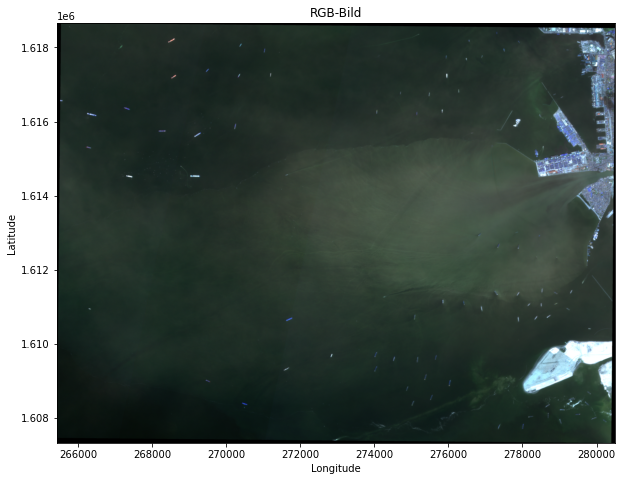

In [9]:
# Pfad zur Rasterdatei definieren
raster_path = "/zfl_data/PlanetScopeData/PSScene/20241206_015845_21_24b4_3B_AnalyticMS_SR_8b_clip.tif"

# Rasterdatei öffnen und Metadaten extrahieren
with rasterio.open(raster_path) as src:
    img = src.read()
    crs = src.crs
    meta = src.meta
    transform = src.transform  # Affine Transformation
    image_shape = (src.height, src.width)

# Begrenzungen für die Darstellung berechnen
left, top = transform * (0, 0)
right, bottom = transform * (img.shape[2], img.shape[1])
extent_raster = [left, right, bottom, top]

# Vorverarbeitung der Bilddaten
img = img.astype(np.float32) / img.max()  # Normalisierung
img_rgb = np.dstack((img[1], img[3], img[5]))  # Kanäle für RGB auswählen

# RGB-Bild darstellen
plot_function(img_rgb, "RGB-Bild", brightness_factor=3, colour_ramp=None, extent=extent_raster)


#### 5. Erstellung einer Wassermaske

Die Schiffsdetektion wird in diesem Skript durch den K-Means-Segmentierungsalgorithmus ermöglicht. Er ist in der Lage, Schiffe anhand ihrer optischen Unterschiede zur Umgebung zu erkennen. Da Schiffe und Wasser unterschiedliche optische Eigenschaften aufweisen, lassen sie sich leicht in zwei verschiedene Klassen segmentieren. Schwierig wird es jedoch, wenn es um den Unterschied zwischen Schiffen und Land geht, die ähnliche optische Eigenschaften haben. Die Schiffsdetektion wird daher einfacher, wenn das Land vor der Anwendung des K-Means-Algorithmus ausgeschlossen wird. 

Hier wird eine einfache Maske erstellt, die zwischen Land- und Wasserflächen unterscheidet. Dazu wird der normalisierte Differenzwasserindex (NDWI) berechnet. Basierend auf dem NDWI wird die Szene in eine binäre Maske umklassifiziert, wobei alle Werte über einem Schwellenwert von -0,05 zum Wasser gehören. Die umklassifizierte Szene wird dann polygonisiert und alle Polygone, die kleiner als 12.000 m² sind, werden ausgeschlossen, da sie höchstwahrscheinlich zu Schiffen gehören. **Falls Sie diesen Workflow auf eine andere Szene anwenden möchten, müssen sie womöglich einen anderen Schwellenwert verwenden.**

/tmp/ipykernel_1048549/3879074131.py:5: RuntimeWarning: invalid value encountered in divide
  ndwi = (img[3] - img[7]) / (img[3] + img[7])


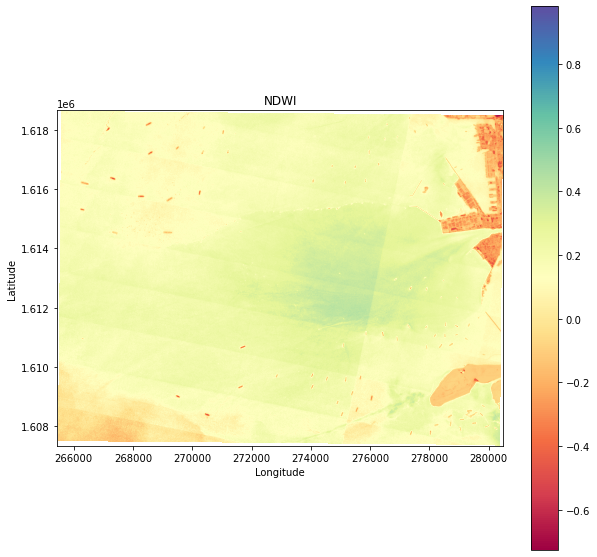

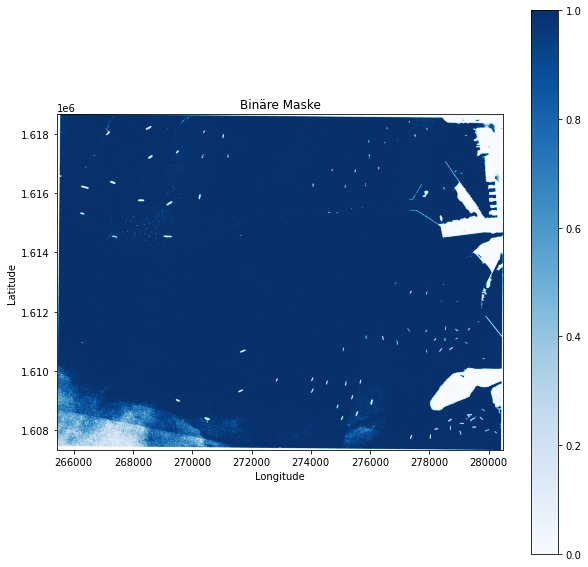

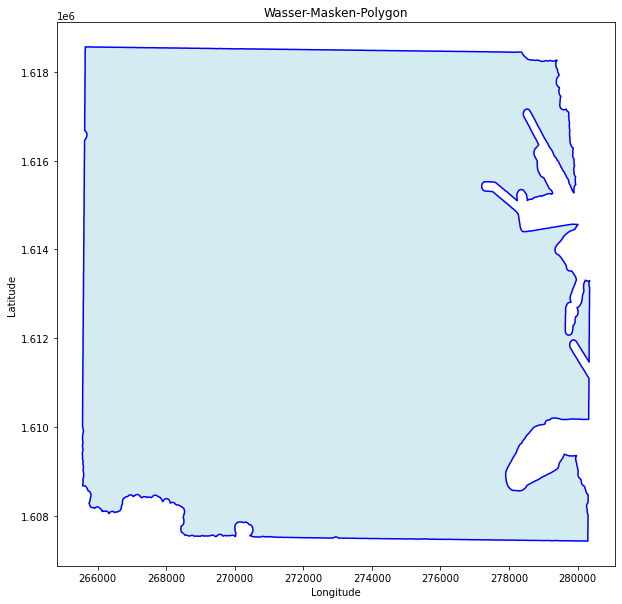

In [10]:
# Polygon aus Raster-Begrenzungen erstellen
extent = box(*src.bounds)

# NDWI (Normalized Difference Water Index) berechnen
ndwi = (img[3] - img[7]) / (img[3] + img[7])

# Binäre Wassermaske erstellen (NDWI >= Schwellenwert)
water_mask = ndwi >= -0.05
water_mask_uint8 = water_mask.astype(np.uint8)

# Visualisierung der Maske
plot_function(ndwi, "NDWI", brightness_factor=0, colour_ramp="Spectral", extent=extent_raster)
plot_function(water_mask_uint8, "Binäre Maske", brightness_factor=0, colour_ramp="Blues", extent=extent_raster)

# Umwandlung der Maske in Vektor-Polygone
shapes = rasterio.features.shapes(water_mask_uint8, mask=None, transform=transform)

# Konvertierung der Shapes in Shapely-Polygone (nur Wasserregionen)
polygons = [shape(geom) for geom, value in shapes if value == 0]

# GeoDataFrame erstellen und Flächen berechnen
gdf = gpd.GeoDataFrame(geometry=polygons, crs=src.crs)
gdf['area'] = gdf.geometry.area

# Polygone filtern (mindestens 12.000 m²)
gdf_filtered = gdf[gdf['area'] >= 12000]

# Vereinigen der gefilterten Polygone zur Differenzberechnung
polygon_to_subtract = gdf_filtered.unary_union

# Differenz-Operation: Begrenzungspolygon minus Wasser-Polygone
water_mask_polygon = extent.difference(polygon_to_subtract)

# Negativen Puffer anwenden (-100 Meter)
buffered_water_mask_polygon = water_mask_polygon.buffer(-100)

# Erstellen des finalen GeoDataFrame
gdf_water_mask = gpd.GeoDataFrame(geometry=[buffered_water_mask_polygon], crs=crs)

# Endgültige Darstellung
plot_function(image=None, title="Wasser-Masken-Polygon", brightness_factor=0, colour_ramp=None, polygon=buffered_water_mask_polygon)

#### 6. Kantenerkennung

K-Means-Algorithmen sollten Schiffe anhand ihrer Farbe und Helligkeit, aber auch anhand der Kantenintensitätswerte erkennen. Daher wird die Kantenerkennung mit dem Canny-Algorithmus auf einem eindimensionalen Graustufenbild durchgeführt. Die Bildsegmente werden dadurch klar strukturiert und weniger verrauscht, sodass sich Schiffe und Wasser leichter unterscheiden lassen. Die Kantenerkennung wird nur innerhalb der Wassermaske angewendet. **Falls Sie den Workflow auf eine andere Szene anwenden möchten, müssen Sie womöglich bei den Paramtern für die Kantenerkennung Anpassungen vornehmen. Am besten probieren sie verschiedene Werte aus und nutzen die Plot Funktion, um die Ergebnisse zu pürfen.**

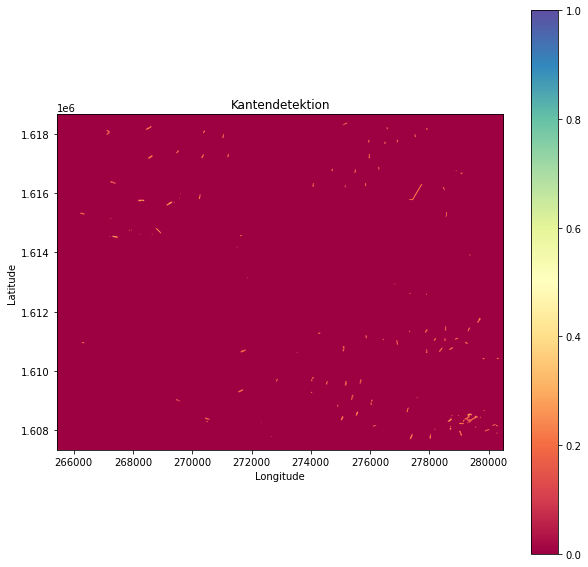

In [11]:
# Konvertierung des RGB-Bildes in Graustufen
gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Konvertiert das gepufferte Polygon in eine Rastermaske unter Verwendung des Bild-Koordinatensystems
buffered_water_mask = rasterize(
    [(buffered_water_mask_polygon, 1)],  # Geometrie des Polygons
    out_shape=image_shape,  # Stellt sicher, dass die Maske zur Bildgröße passt
    transform=transform,  # Wendet die Raster-Transformation zur Ausrichtung an
    fill=0,  # Hintergrund ist 0
    default_value=1  # Wasser-Maske ist 1
).astype(np.uint8)  # Konvertierung zu uint8

# Kantendetektion mit dem Canny-Algorithmus
edges = cv2.Canny((gray * 255).astype(np.uint8), 0, 50)

# Anwenden der Maske: Behält Kanten nur innerhalb des gepufferten Wasser-Polygons
masked_edges = cv2.bitwise_and(edges, edges, mask=buffered_water_mask)

# Normalisierung der Ergebnisse auf den Bereich 0 bis 1
masked_edges = masked_edges / 255

# Darstellung der Kantendetektion
plot_function(image=masked_edges, title="Kantendetektion", brightness_factor=0, colour_ramp="Spectral", extent=extent_raster)

#### 7. K-Means Clustering 

Vor der Anwendung von K-Means werden nur Pixel innerhalb der Wassermaske ausgewählt, um sicherzustellen, dass die Clusterbildung ausschließlich in Wasserbereichen erfolgt. Der Algorithmus wird dann mit zwei Clustern initialisiert, um zwischen Schiffen und Wasser zu unterscheiden. Um die Reproduzierbarkeit zu gewährleisten, wird die Zufälligkeit auf Null gesetzt. Die anfänglichen Zentren werden mit der K-Means++-Initialisierung strategisch über die Szene verteilt. Jedes Pixel wird anhand der euklidischen Distanz unter Berücksichtigung von Merkmalen wie Farbe, Helligkeit und Kantenintensität dem nächstgelegenen Zentroid zugeordnet. Der Prozess der Zentroidzuordnung wird zehnmal wiederholt, um die Segmentierung zu verfeinern und sicherzustellen, dass jedes Pixel optimal dem am besten geeigneten Cluster zugeordnet wird. Das Ergebnis ist eine Segmentierung, die anschließend neu klassifiziert wird, wobei Cluster mit dem Werte 1 Schiffe darstellt, während der andere dem Hintergrundwasser entspricht.

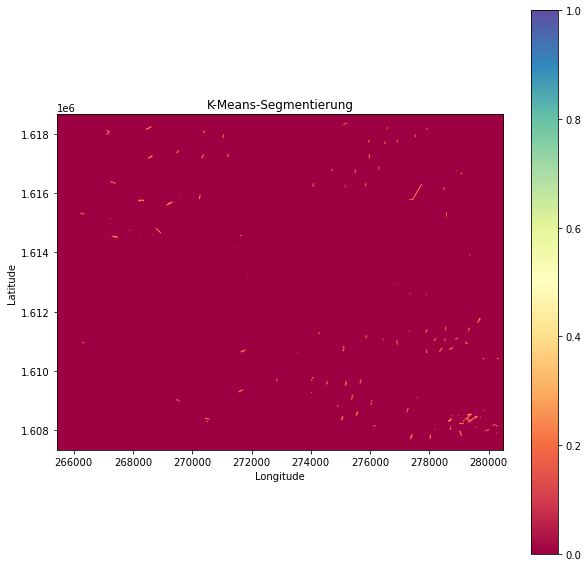

In [12]:
# Extrahieren der Kantenpixel (aus 'edges') nur innerhalb der Wasser-Maske
edge_pixels_in_water = edges[buffered_water_mask == 1]

# Kantenpixel in das (Anzahl_Samples, 1) Format umformen
edge_pixels_reshaped = edge_pixels_in_water.reshape(-1, 1)

# Anwendung des K-Means-Clustering (2 Cluster) nur auf die Kantenpixel im Wasserbereich
kmeans = KMeans(n_clusters=2, init="k-means++", random_state=0, n_init=10).fit(edge_pixels_reshaped)

# Abrufen der Cluster-Labels
segmented_labels = kmeans.labels_.astype(np.uint8)

# Zuordnen von Werten zu Clustern von Intensitätswerten
if np.mean(edge_pixels_reshaped[segmented_labels == 0]) > np.mean(edge_pixels_reshaped[segmented_labels == 1]):
    ship_cluster = 0 
else:
    ship_cluster = 1 

# Erstellen eines leeren segmentierten Bildes
segmented_img = np.zeros_like(edges, dtype=np.uint8)

# Zuweisen der Schiff-Cluster-Pixel zum Bild (innerhalb der Wasser-Maske)
segmented_img[buffered_water_mask == 1] = (segmented_labels == ship_cluster)  # Schiffe = weiß (1)

# Darstellung der K-Means-Segmentierung
plot_function(image=segmented_img, title="K-Means-Segmentierung", brightness_factor=0, colour_ramp="Spectral", extent=extent_raster)

#### 8. Rauschentfernung

Dieser Codeabschnitt wendet eine morphologische Operation auf die neu klassifizierte K-Means-Segmentierungsmaske an, um Rauschen mit einem 9x9-Kernel zu entfernen und so das Segmentierungsergebnis zu verbessern.

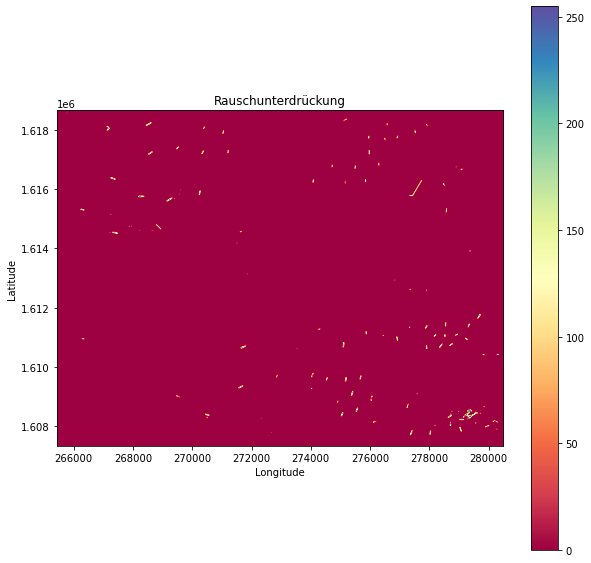

In [13]:
# Vorbereitung der Segmentierungsmaske
kernel = np.ones((9, 9), np.uint8)  # Strukturelement für morphologische Operation

# Skalierung der Werte auf 0-255 und Konvertierung zu uint8
segmented_img = (segmented_img * 255).astype(np.uint8)

# Anwendung der morphologischen Schließung (MORPH_CLOSE) zur Entfernung von Rauschen
processed = cv2.morphologyEx(segmented_img, cv2.MORPH_CLOSE, kernel)

# Darstellung des Bildes nach der Rauschunterdrückung
plot_function(image=processed, title="Rauschunterdrückung", brightness_factor=0, colour_ramp="Spectral", extent=extent_raster)

#### 9. Polygonisierung

In diesem Abschnitt werden verbundene Komponenten, die Schiffe darstellen, beschriftet und in Polygone umgewandelt. Nach einer Umwandlung von Pixelkoordinaten in reale geografische Koordinaten werden die Polygone nach kleinen oder extrem großen Ausreißern gefiltert und schließlich in einem GeoDataFrame gespeichert. **Auch hier können Anpassungen vorgenommen werden. Beispielsweise können Sie auch versuchen kleiner Schiffe und größere Schiffe besser dazustellen, indem Sie diese nicht mehr als Außreißer herausfiltern. Dafür müssen Sie die Schwellenwerte anpassen.**

In [14]:
# Markieren der verbundenen Komponenten (potenzielle Schiffe) im verarbeiteten Bild
labeled_array, num_features = label(processed, return_num=True)

# Konvertierung der Regionen in Vektordaten (Polygone)
polygons = []
for region in regionprops(labeled_array):
    if region.area > 10:  # Kleine Regionen ignorieren
        minr, minc, maxr, maxc = region.bbox  # Begrenzungsrahmen (Zeile, Spalte)

        # Konvertierung der Pixelkoordinaten in Weltkoordinaten (geospatial)
        x_min, y_min = rasterio.transform.xy(transform, minr, minc, offset="center")
        x_max, y_max = rasterio.transform.xy(transform, maxr - 1, maxc - 1, offset="center")

        # Erstellen eines Polygons unter Verwendung der korrigierten Koordinaten
        polygon = Polygon([(x_min, y_min), (x_max, y_min), (x_max, y_max), (x_min, y_max)])
        
        # Prüfen, ob die Fläche des Polygons innerhalb eines bestimmten Bereichs liegt (1.000 m² bis 24.000 m²)
        if polygon.area <= 24000 and polygon.area >= 1000:
            polygons.append(polygon)

# Erstellen eines GeoDataFrame mit dem korrekten CRS
gdf_ships = gpd.GeoDataFrame(geometry=polygons, crs=crs)

#### 10. Visualisierung

Die erkannten Schiffsrümpfe werden nun dargestellt. Dafür werden die Polygone der Schiffe in rot dargestellt und über das RGB der PlanetScope Szene gelegt. Außerdem sieht man die Wassermaske. Letztere hat relativ gut die Landflächen herausgefiltert, aber auch zwei Schiffe auf der linken Seite des Bildes wurden fälschlicherweise gefiltert. Abgesehen davon wurden sehr viele Schiffe richtig erkannt - einige kleiner Boote auf der mittleren rechten Seite wurden jedoch ausgelassen. Wahrscheinlich sind sie zu klein oder heben sich optisch zu wenig vom Hintergrund ab. 

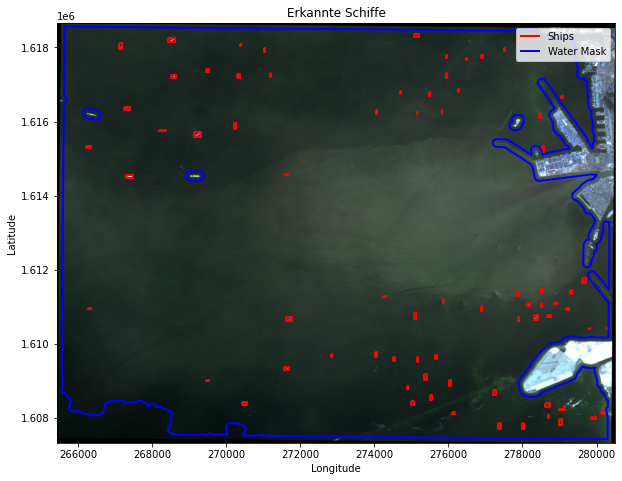

Anzahl der erkannten Schiffe: 74


In [15]:
# Plotten des RGB-Bildes zusammen mit den erkannten Schiffen (gdf_ships) und der Wasser-Maske (gdf_water_mask)
plot_function(image=img_rgb, title="Erkannte Schiffe", brightness_factor=3, colour_ramp=None, 
                polygon=None, ships=gdf_ships, mask=gdf_water_mask, extent=extent_raster)

# Ausgabe der Gesamtzahl der erkannten Schiffe (basierend auf der Anzahl der erstellten Polygone)
print("Anzahl der erkannten Schiffe:", len(polygons))